POC1 realized by DIMEGLIO Nicolas.

# Multiclassifier (CNN)

## Analysis Performed :
        - Graph containing the evolution of the training error and the test error
        - Graph the evolution of the accuracy for these datasets.
        - The analysis of these results, including the trade-off between bias and variance (or overlearning and underlearning).

## Import of different libraries:

In [15]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from datetime import time

## Data recovery :
Once the datasets are set up, select the dataset to use in the `data_dir` variable

In [16]:
##Dataset
data_dir = "../Dataset/DatasetTest"
data_dir = pathlib.Path(data_dir)

To start, we need to specify some parameters for the training :
    - The length and width of the images.
    - The size of the batch.

In [17]:
image_h = 180
image_w = 180
batch_s = 32

## Data preparation :

We need to share the dataset in training and validation set.

## Data standardization :
We will use the function to create a dataset by directory.
<br> The function will transform the images to match the defined length and width.
<br> The images can be in different formats. Nous normalisons les images en les transformant en image couleur rgb.

Our datasets are therefore composed of images in 180 by 180 and composed of 3 color dimensions.

In [18]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

Found 23 files belonging to 2 classes.
Using 19 files for training.
Found 23 files belonging to 2 classes.
Using 4 files for validation.


We get back the number of images that constitute our training and test games.

## Data mining and visualization
Let's start by displaying the names of the different classes in our data.

In [19]:
class_names =  train_set.class_names
print(class_names)

['Car', 'Fire hydrant']


In [20]:
nb_classes = len(class_names)

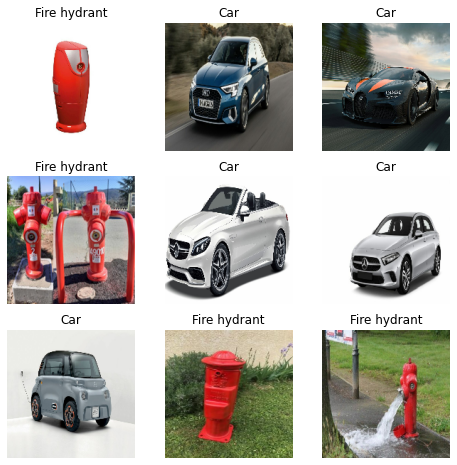

In [21]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

(19, 180, 180, 3)
(19,)


## Configuration of the training environment

- `Dataset.cache()` : This function is used to force the data to be cached in memory. Since the neural network makes several passes (called _epoch_) on the data during the learning process, this function avoids having to reload the images each time.
- `Dataset.prefetch()` : This function allows to do the preprocessing of the current element of the dataset (for example the next batch) at the same time as the training/evaluation of the current batch by the model. In a multi-processor or multi-core environment, this is a significant time saving.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

#### Model backup
We have chosen to implement a function to save the best models running at regular intervals.
This allows us to recover the best performing models.

In [24]:
name = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint_filepath = './model/' + name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    #save_freq="epoch",
    save_best_only=True)

#### Cost function / Optimizer / Metrics

The choice of the cost function for our CNN depends on the data format and the neural network.
In our case, we want to perform a multi-classification, and our data are in numerical format. So we choose an adapted cost function here the `SparseCategoricalCrossentropy`.
<br>The `adam` optimizer is one of the most used optimizers. It allows a fast convergence, which reduces the training time.
<br>For our classification we choose to look at the `accuracy`, which is the most relevant to compare the results of our model.

In [25]:
function_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = 'adam'
metric = ['accuracy']

#### Modèle au complet :

In [26]:
# Résumé du modèle
def create_model(num_classes =nb_classes,
                 loss_fn_to_use = function_loss,
                 optimizer_to_use = optimizer,
                 metrics_to_use = metric):

    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical",seed=42,input_shape=(image_h, image_w, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(
            factor = (-0.2, 0.3),
            fill_mode="reflect",
            interpolation="bilinear",
            seed=42,
            fill_value=0.0,
        ),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor= (0.2, 0.3),
            width_factor=None,
            fill_mode="reflect",
            interpolation="bilinear",
            seed=42,
            fill_value=0.0,
        ),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0),
        tf.keras.layers.Conv2D(64, [3,3], activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(8, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(
            rate=0.2, noise_shape=None, seed=42,
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes),
    ])

    #Set Loss Function
    loss_fn=loss_fn_to_use
    #On compile le modèle.
    model.compile(optimizer = optimizer_to_use,
                  loss = loss_fn,
                  metrics= metrics_to_use)
    return model

After compiling the model, we will train our neural network with the normalized data.

In [ ]:
epochs=25

tf.debugging.set_log_device_placement(True)
#start = time.time()

model = create_model()
if tf.test.is_gpu_available():
    with tf.device('/gpu:0'):
        history = model.fit(train_set,validation_data = test_set,epochs=epochs, callbacks=[model_checkpoint_callback])
else:
    history = model.fit(train_set,validation_data = test_set,epochs=epochs, callbacks=[model_checkpoint_callback])

#end = time.time()
#elapsed = end - start

#print(f'Temps d\'exécution : {elapsed:.2}ms')

model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.6965 - accuracy: 0.3684 - val_loss: 0.6720 - val_accuracy: 0.7500
Epoch 2/25
1/1 [==============================] - 1s 839ms/step - loss: 0.6819 - accuracy: 0.5263 - val_loss: 0.6583 - val_accuracy: 0.7500
Epoch 3/25
1/1 [==============================] - 1s 865ms/step - loss: 0.6792 - accuracy: 0.6316 - val_loss: 0.6402 - val_accuracy: 0.7500
Epoch 4/25
1/1 [==============================] - 1s 796ms/step - loss: 0.6593 - accuracy: 0.6316 - val_loss: 0.6233 - val_accuracy: 0.7500
Epoch 5/25
1/1 [==============================] - 1s 687ms/step - loss: 0.6686 - accuracy: 0.6316 - val_loss: 0.6060 - val_accuracy: 0.7500
Epoch 6/25
1/1 [==============================] - 1s 861ms/step - loss: 0.6497 - accuracy: 0.6316 - val_loss: 0.5916 - val_accuracy: 0.7500
Epoch 7/25
1/1 [==============================] - 1s 797ms/step - loss: 0.6328 - accuracy: 0.6316 - val_loss: 0.5787 - val_accuracy: 0.7500
Epoch 8/25
1/1 [=======

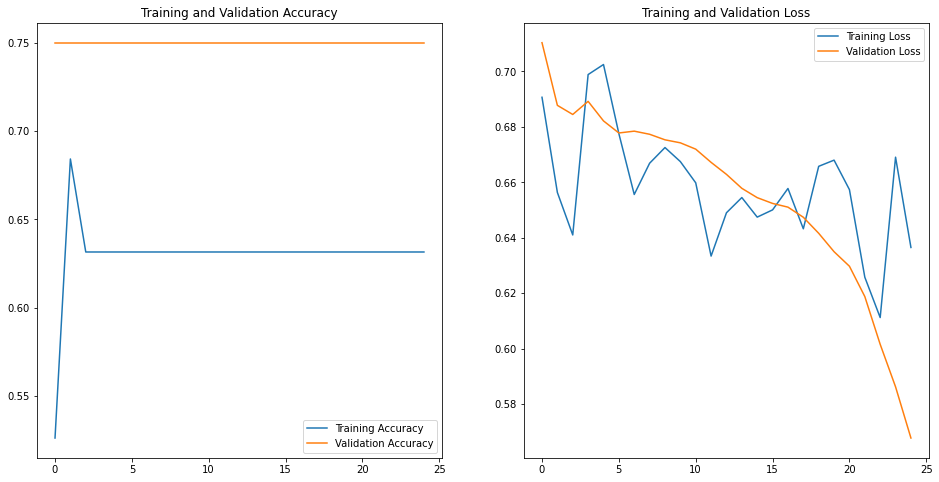

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("images/Courbe_loss_et_accuracy.png")
plt.show()

## Use saved model

Results of the saved model.

In [29]:
new_model = tf.keras.models.load_model('./model/my_best_model.epoch21-loss0.58.hdf5')
score, accuracy = new_model.evaluate(test_set, batch_size=batch_s)
print('Loss : ', score)
print('Global Accuracy : ', accuracy)

1/1 [==============================] - 0s 134ms/step - loss: 0.7980 - accuracy: 0.0000e+00
Loss :  0.7980168461799622
Global Accuracy :  0.0


1/1 [==============================] - 0s 118ms/step


C:\Users\ndimegli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['Car', 'Fire hydrant'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


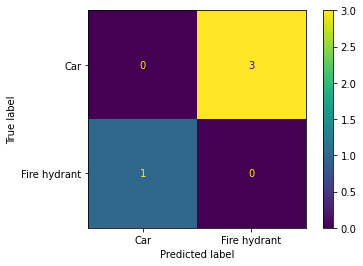

In [30]:
from sklearn import metrics

predictions = new_model.predict(test_set,verbose=1)

list_labels = []
for image_batch, label_batch in test_set:
    [list_labels.append(y.numpy()) for y in label_batch]

new_confus_mtx = sk.metrics.confusion_matrix(list_labels,predictions.argmax(axis=1))

disp = sk.metrics.ConfusionMatrixDisplay(new_confus_mtx,class_names)
disp.plot()

In [31]:
per_class_accuracies = {}
# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(range(len(class_names))):
    true_negatives = np.sum(np.delete(np.delete(new_confus_mtx, idx, axis=0), idx, axis=1))
    true_positives = new_confus_mtx[idx, idx]
    per_class_accuracies[class_names[cls]] = (true_positives + true_negatives) / np.sum(new_confus_mtx)
print(per_class_accuracies)

{'Car': 0.0, 'Fire hydrant': 0.0}
